In [1]:
import os
import cv2
import numpy as np

def load_data():
  base_folder = 'tpc-imgs'
  toxic_folder = f'{base_folder}/toxic_images'
  nontoxic_folder = f'{base_folder}/nontoxic_images'

  toxic_paths = [os.path.join(dp, f) for dp, dn, filenames  in os.walk(toxic_folder) for f in filenames if os.path.splitext(f)[1] == '.jpg']
  nontoxic_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(nontoxic_folder) for f in filenames if os.path.splitext(f)[1] == '.jpg']

  toxic_imgs = [cv2.imread(path) for path in toxic_paths]
  nontoxic_imgs = [cv2.imread(path) for path in nontoxic_paths]

  return toxic_imgs, nontoxic_imgs


data = load_data()


In [2]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [3]:
toxic_imgs, nontoxic_imgs = data
IMG_SHAPE = (224, 224, 3)
prepared_toxic_imgs = np.array([cv2.resize(img, IMG_SHAPE[:2]) for img in toxic_imgs])
prepared_nontoxic_imgs = np.array([cv2.resize(img, IMG_SHAPE[:2]) for img in nontoxic_imgs])

In [4]:
toxic_labels = np.array([[1, 0] for _ in range(len(prepared_toxic_imgs))])
nontoxic_labels = np.array([[0, 1] for _ in range(len(prepared_nontoxic_imgs))])

X = np.vstack((prepared_toxic_imgs, prepared_nontoxic_imgs))
y = np.vstack((toxic_labels, nontoxic_labels))

X, y = shuffle(X, y, random_state=42)
y = np.argmax(y, axis=1)

# Split the data into temporary and testing (combined test/validation) sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.105, random_state=42)

# Split the temporary set into the actual test and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.12, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)


(7838, 224, 224, 3) (7838,) (1045, 224, 224, 3) (1045,) (1069, 224, 224, 3) (1069,)


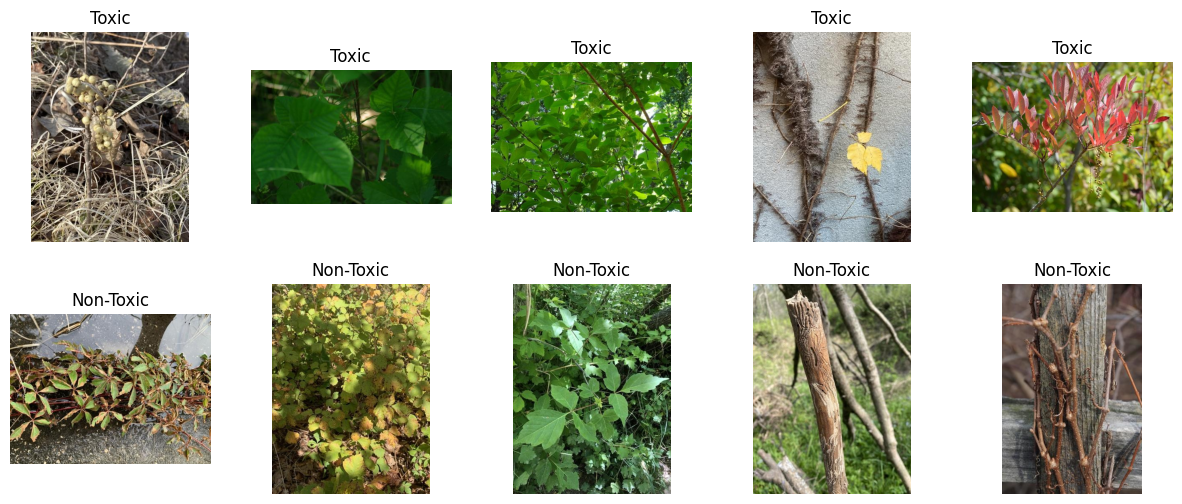

In [5]:
import random
import matplotlib.pyplot as plt

def display_random_images(toxic_imgs, nontoxic_imgs, num_toxic=5, num_nontoxic=5):
    random_toxic_imgs = random.sample(toxic_imgs, num_toxic)
    random_nontoxic_imgs = random.sample(nontoxic_imgs, num_nontoxic)

    plt.figure(figsize=(15, 6))

    for i, img in enumerate(random_toxic_imgs):
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Toxic')
        plt.axis('off')

    for i, img in enumerate(random_nontoxic_imgs):
        plt.subplot(2, 5, num_toxic + i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Non-Toxic')
        plt.axis('off')

    plt.show()

# Use the function to display 5 toxic and 5 non-toxic images
display_random_images(toxic_imgs, nontoxic_imgs, num_toxic=5, num_nontoxic=5)


In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

for layer in base_model.layers:
    layer.trainable = False

2023-12-02 22:29:28.689728: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-12-02 22:29:28.689753: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-02 22:29:28.689760: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-02 22:29:28.689795: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-02 22:29:28.689811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
import platform

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Binary classification, adjust if needed

if platform.system() == "Darwin" and platform.processor() == "arm":
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
else:
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# Callback to save weights of the best model based on validation accuracy
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p1/',  # Specify the path where you want to save the weights
    save_weights_only=True,
    save_best_only=True,  
    monitor='val_accuracy',  
    mode='max',  
    verbose=1  
)

history_transfer_p1 = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Epoch 1/20


2023-12-02 22:29:38.614533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


245/245 [==============================] - ETA: 0s - loss: 0.6953 - accuracy: 0.6319

2023-12-02 22:30:01.644213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.68569, saving model to /Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p1/
245/245 [==============================] - 28s 103ms/step - loss: 0.6953 - accuracy: 0.6319 - val_loss: 0.5891 - val_accuracy: 0.6857
Epoch 2/20
245/245 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.7091
Epoch 2: val_accuracy did not improve from 0.68569
245/245 [==============================] - 22s 91ms/step - loss: 0.5720 - accuracy: 0.7091 - val_loss: 0.6216 - val_accuracy: 0.6791
Epoch 3/20
245/245 [==============================] - ETA: 0s - loss: 0.5342 - accuracy: 0.7314
Epoch 3: val_accuracy improved from 0.68569 to 0.74181, saving model to /Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p1/
245/245 [==============================] - 23s 93ms/step - loss: 0.5342 - accuracy: 0.7314 - val_loss: 0.5261 - val_accuracy: 0.7418
Epoch 4/20
245/245 [=============================

In [ ]:
eval_result = model.evaluate(X_test, y_test)
print(f"Test loss: {eval_result[0]}, Test accuracy: {eval_result[1]}")

2023-12-02 21:47:00.122824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 4s 95ms/step - loss: 50.6424 - accuracy: 0.5221
Test loss: 50.64238357543945, Test accuracy: 0.522088348865509
